In [184]:
import pandas as pd
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import stats
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')
from matplotlib.ticker import AutoMinorLocator
from scipy.stats import shapiro, jarque_bera
from uncertainties import ufloat
from uncertainties.umath import log10

In [185]:
# Convert to logarithmic scale with error propagation
def log_error_propagation(values, errors, base=10):
    if base == 10:
        log_values = np.log10(values)
        log_errors = errors / (values * np.log(10))
    else:
        log_values = np.log(values)
        log_errors = errors / values
    return log_values, log_errors

def log_error_propagation_upper_limit(values, base=10):
    if base == 10:
        log_values = np.log10(values)
        
    else:
        log_values = np.log(values)
        
    return log_values

In [186]:
# Reading Detection Data
detection_data = pd.read_csv('Detection_data.csv')
detection_data = detection_data[["Source", "YSO Classification","Nir_Flux[erg/s/cm^2]", "Nir_Flux_err[erg/s/cm^2]", "Radio_Flux[mJy]","Radio_Flux_err[mJy]"]]


#Keeping the Source_exclude data separately
data_exclude = detection_data[detection_data['Source'] == 'Source_exclude'].reset_index(drop=True)

# Exclude Source_exclude from fitting (keep for plotting only)
data_fit = detection_data[detection_data['Source'] != 'Source_exclude'].reset_index(drop=True)
data_fit['Detection'] =  ['True'] * len(data_fit)
data_fit = data_fit[data_fit["YSO Classification"].isin(["ClassII", "ClassI"])]


print("Processed Detection Data (for fitting):\n",data_fit)

Processed Detection Data (for fitting):
        Source YSO Classification  Nir_Flux[erg/s/cm^2]  \
2    Source_3             ClassI          2.465833e-14   
3    Source_4            ClassII          3.907967e-15   
4    Source_5            ClassII          8.632008e-18   
5    Source_6            ClassII          8.629132e-18   
6    Source_7             ClassI          2.231011e-18   
7    Source_8            ClassII          1.574189e-13   
9   Source_10            ClassII          1.771885e-14   
10  Source_11            ClassII          1.328945e-18   
12  Source_13            ClassII          9.877700e-14   
15  Source_16            ClassII          1.260164e-17   
16  Source_17            ClassII          6.690421e-17   
17  Source_18            ClassII          1.407792e-15   
18  Source_19            ClassII          3.905441e-16   
19  Source_20             ClassI          5.589524e-17   
20  Source_21            ClassII          4.689401e-15   
21  Source_22            ClassI

In [187]:
#Reading upper limit data
upper_limit_data = pd.read_csv('Upper_limit_data.csv')
upper_limit_data2 = upper_limit_data[["Name", "YSO Classification", " sigma_radio [mJy]", "sigma_nir [erg / s/cm2]"]] 

# Tries to read the data as float or integer. If any entry is non-numeric or empty it automatically assigns Nan to it
upper_limit_data2.loc[:, " sigma_radio [mJy]"] = pd.to_numeric(upper_limit_data2[" sigma_radio [mJy]"], errors="coerce")
upper_limit_data2.loc[:, "sigma_nir [erg / s/cm2]"] = pd.to_numeric(upper_limit_data2["sigma_nir [erg / s/cm2]"], errors="coerce" )

# Replace inf values with NaN and drop rows with NaN
upper_limit_data_clean = upper_limit_data2.replace([np.inf, -np.inf], np.nan).dropna()
upper_limit_data_clean = upper_limit_data_clean[upper_limit_data_clean["YSO Classification"].isin(["ClassII", "ClassI"])] #Keeping only ClassII and ClassI sources
upper_limit_data_clean['Detection'] =  ['False'] * len(upper_limit_data_clean)


Nir_sigma = upper_limit_data_clean['sigma_nir [erg / s/cm2]'].to_numpy()
radio_sigma = upper_limit_data_clean[" sigma_radio [mJy]"].values 

print('Processed Upper Limit Data (for fitting):\n',upper_limit_data_clean)

Processed Upper Limit Data (for fitting):
             Name YSO Classification   sigma_radio [mJy]  \
0    UL_Source_1            ClassII        2.120590e-22   
2    UL_Source_3            ClassII        7.977806e-22   
4    UL_Source_5            ClassII        2.544273e-23   
5    UL_Source_6            ClassII        1.441544e-23   
6    UL_Source_7            ClassII        2.376851e-21   
7    UL_Source_8            ClassII        5.340258e-22   
8    UL_Source_9             ClassI        1.576653e-23   
10  UL_Source_11            ClassII        1.309761e-21   
11  UL_Source_12             ClassI        9.774871e-23   
12  UL_Source_13             ClassI        2.395954e-22   
13  UL_Source_14            ClassII        2.914881e-23   
14  UL_Source_15            ClassII        5.978250e-24   
15  UL_Source_16             ClassI        8.469884e-22   
16  UL_Source_17            ClassII        9.221417e-22   
17  UL_Source_18            ClassII        3.278654e-22   
18  UL_Source

In [188]:
# Convert the fluxes to log10 scale and add log-transformed columns to the data frames 
data_fit[["log10(Nir_flux)", "log10(Nir_flux_err)"]] = data_fit.apply( lambda row: pd.Series(log_error_propagation(row["Nir_Flux[erg/s/cm^2]"], row["Nir_Flux_err[erg/s/cm^2]"], base=10)), axis=1 )
data_fit[["log10(Radio_flux)", "log10(Radio_flux_err)"]] =   data_fit.apply( lambda row: pd.Series(log_error_propagation(row["Radio_Flux[mJy]"], row["Radio_Flux_err[mJy]"], base=10)), axis=1 )

upper_limit_data_clean.loc[:, "log10(Nir_flux)"] = log_error_propagation_upper_limit(Nir_sigma, base=10)
upper_limit_data_clean.loc[:, "log10(Nir_flux_err)"] = 0.1 * abs(log_error_propagation_upper_limit(Nir_sigma, base=10))
upper_limit_data_clean.loc[:, "log10(Radio_flux)"] = log_error_propagation_upper_limit(3 * radio_sigma, base=10)
upper_limit_data_clean.loc[:, "log10(Radio_flux_err)"] = 0.1 * abs(log_error_propagation_upper_limit(3 * radio_sigma, base=10))



In [189]:
#Assigning the values to the detected variables and upper limit variables respectively


x_det = data_fit['log10(Nir_flux)'].values
y_det = data_fit['log10(Radio_flux)'].values
x_err_det = data_fit['log10(Nir_flux_err)'].values
y_err_det = data_fit['log10(Radio_flux_err)'].values
detection = data_fit['Detection'].values

x_ul = upper_limit_data_clean["log10(Nir_flux)"].values
y_ul = upper_limit_data_clean["log10(Radio_flux)"].values
x_err_ul = upper_limit_data_clean["log10(Nir_flux_err)"].values
y_err_ul = upper_limit_data_clean["log10(Radio_flux_err)"].values


print(f"\nDetections used for fitting (N={len(x_det)}):")
det_names = data_fit['Source'].values
for i, name in enumerate(det_names):
    print(f"{name}: x = {x_det[i]:.3f} ± {x_err_det[i]:.3f}, y = {y_det[i]:.3f} ± {y_err_det[i]:.3f}")

print(f"\nUpper Limits used for fitting (N={len(x_ul)}):")
ul_names = upper_limit_data_clean["Name"]
for i, name in enumerate(ul_names):   
    print(f"{name}: x < {x_ul[i]:.3f} ± {x_err_ul[i]:.3f}, y < {y_ul[i]:.3f} ± {y_err_ul[i]:.3f}")


Detections used for fitting (N=21):
Source_3: x = -13.608 ± 0.049, y = -19.095 ± 0.045
Source_4: x = -14.408 ± 0.126, y = -19.427 ± 0.050
Source_5: x = -17.064 ± 0.127, y = -21.393 ± 0.045
Source_6: x = -17.064 ± 0.114, y = -21.709 ± 0.085
Source_7: x = -17.651 ± 0.070, y = -21.807 ± 0.064
Source_8: x = -12.803 ± 0.052, y = -18.520 ± 0.077
Source_10: x = -13.752 ± 0.082, y = -19.034 ± 0.060
Source_11: x = -17.876 ± 0.054, y = -21.859 ± 0.070
Source_13: x = -13.005 ± 0.046, y = -18.730 ± 0.058
Source_16: x = -16.900 ± 0.101, y = -21.183 ± 0.054
Source_17: x = -16.175 ± 0.071, y = -20.894 ± 0.104
Source_18: x = -14.851 ± 0.089, y = -19.924 ± 0.096
Source_19: x = -15.408 ± 0.091, y = -20.452 ± 0.085
Source_20: x = -16.253 ± 0.059, y = -21.056 ± 0.100
Source_21: x = -14.329 ± 0.128, y = -19.408 ± 0.096
Source_22: x = -17.163 ± 0.111, y = -21.311 ± 0.056
Source_23: x = -16.247 ± 0.125, y = -20.884 ± 0.102
Source_24: x = -15.802 ± 0.121, y = -20.411 ± 0.079
Source_26: x = -13.289 ± 0.124, y

In [190]:
def log_likelihood(theta, x_det, y_det, x_err_det, y_err_det, x_ul, y_ul, x_err_ul):
    slope, intercept, log_sigma_int = theta
    sigma_int = np.exp(log_sigma_int)
    
    y_model_det = slope * x_det + intercept
    sigma_total_det = np.sqrt(y_err_det**2 + sigma_int**2 + (slope * x_err_det)**2)
    ll_det = -0.5 * np.sum((y_det - y_model_det)**2 / sigma_total_det**2 + np.log(2 * np.pi * sigma_total_det**2))
    
    y_model_ul = slope * x_ul + intercept
    sigma_total_ul = np.sqrt(sigma_int**2 + (slope * x_err_ul)**2)
    ll_ul = np.sum(stats.norm.logcdf(y_ul, loc=y_model_ul, scale=sigma_total_ul))
    
    return ll_det + ll_ul

def log_prior(theta):
    slope, intercept, log_sigma_int = theta
    # MODIFIED: Restrict slope to be positive (0 to 10)
    if (0 < slope < 10 and -10 < intercept < 10 and -10 < log_sigma_int < 5):
        return 0.0
    return -np.inf

def log_probability(theta, x_det, y_det, x_err_det, y_err_det, x_ul, y_ul, x_err_ul):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x_det, y_det, x_err_det, y_err_det, x_ul, y_ul, x_err_ul)

# Initial guess using OLS
def ols_fit(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    return np.linalg.lstsq(A, y, rcond=None)[0]

slope_init, intercept_init = ols_fit(x_det, y_det)

"""
# MODIFIED: Ensure initial slope is positive
if slope_init <= 0:
    slope_init = 0.1  # Set to a small positive value if OLS gives negative slope
    print(f"Warning: OLS gave negative slope, setting initial slope to {slope_init}")
"""
initial_guess = [slope_init, intercept_init, np.log(0.01)]

print(f"\nInitial parameter guess:")
print(f"Slope: {slope_init:.3f}")
print(f"Intercept: {intercept_init:.3f}")
print(f"Log intrinsic scatter: {np.log(0.01):.3f}")

# Find maximum likelihood estimate with bounds
from scipy.optimize import minimize

# MODIFIED: Add bounds for optimization to ensure positive slope
bounds = [(0.001, 10), (-10, 10), (-10, 5)]  # slope > 0, intercept free, log_sigma_int free

nll = lambda *args: -log_probability(*args)
result = minimize(nll, initial_guess, args=(x_det, y_det, x_err_det, y_err_det, x_ul, y_ul, x_err_ul), 
                 bounds=bounds, method='L-BFGS-B')
ml_params = result.x

print(f"\nMaximum Likelihood Estimate:")
print(f"Slope: {ml_params[0]:.3f}")
print(f"Intercept: {ml_params[1]:.3f}")
print(f"Intrinsic scatter: {np.exp(ml_params[2]):.3f}")

# MCMC sampling
ndim = 3
nwalkers = 32
nsteps = 3000

# MODIFIED: Initialize walkers with positive slopes only
pos = ml_params + 1e-4 * np.random.randn(nwalkers, ndim)
pos[:, 0] = np.abs(pos[:, 0])  # Ensure all initial slopes are positive
pos[:, 0] = np.maximum(pos[:, 0], 0.001)  # Ensure minimum positive value
pos[:, 2] = ml_params[2] + 0.1 * np.random.randn(nwalkers)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                               args=(x_det, y_det, x_err_det, y_err_det, x_ul, y_ul, x_err_ul))

print("\nRunning MCMC...")
sampler.run_mcmc(pos, nsteps, progress=True)

# Remove burn-in
burnin = 1000
samples = sampler.get_chain(discard=burnin, flat=True)

print(f"\nMCMC Results (after {burnin} burn-in steps):")
print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")

# Check if any slopes are negative (shouldn't happen with proper priors)
negative_slopes = np.sum(samples[:, 0] < 0)
print(f"Number of negative slope samples: {negative_slopes} (should be 0)")

# Parameter estimates
slope_samples = samples[:, 0]
intercept_samples = samples[:, 1]
sigma_int_samples = np.exp(samples[:, 2])

slope_median = np.percentile(slope_samples, 50)
slope_lower = np.percentile(slope_samples, 16)
slope_upper = np.percentile(slope_samples, 84)

intercept_median = np.percentile(intercept_samples, 50)
intercept_lower = np.percentile(intercept_samples, 16)
intercept_upper = np.percentile(intercept_samples, 84)

sigma_int_median = np.percentile(sigma_int_samples, 50)
sigma_int_lower = np.percentile(sigma_int_samples, 16)
sigma_int_upper = np.percentile(sigma_int_samples, 84)

print(f"\nBayesian Parameter Estimates (median ± 1σ):")
print(f"Slope: {slope_median:.3f} +{slope_upper-slope_median:.3f} -{slope_median-slope_lower:.3f}")
print(f"Intercept: {intercept_median:.3f} +{intercept_upper-intercept_median:.3f} -{intercept_median-intercept_lower:.3f}")
print(f"Intrinsic scatter: {sigma_int_median:.3f} +{sigma_int_upper-sigma_int_median:.3f} -{sigma_int_median-sigma_int_lower:.3f}")

# Convert back to physical interpretation
print(f"\nPhysical Interpretation:")
print(f"Power-law relationship: Peak_pb ∝ (Br_gamma_flux)^{slope_median:.3f}")
print(f"Normalization: Peak_pb = 10^{intercept_median:.3f} × (Br_gamma_flux/1)^{slope_median:.3f}")

# Calculate posterior correlation coefficient between x and y
print("\nCalculating posterior correlation coefficient...")
correlation_samples = []
for i in range(len(samples)):
    slope_sample, intercept_sample = samples[i, 0], samples[i, 1]
    # Calculate model predictions for this sample
    y_pred_sample = slope_sample * x_det + intercept_sample
    # Calculate correlation between observed and predicted (goodness of fit measure)
    r_sample = np.corrcoef(y_det, y_pred_sample)[0, 1]
    correlation_samples.append(r_sample)

correlation_samples = np.array(correlation_samples)
correlation_mean = np.mean(correlation_samples)
correlation_median = np.median(correlation_samples)
correlation_std = np.std(correlation_samples)
correlation_ci = np.percentile(correlation_samples, [16, 84])  # 68% CI
correlation_ci_95 = np.percentile(correlation_samples, [2.5, 97.5])  # 95% CI

print(f"Posterior correlation statistics:")
print(f"  Mean: {correlation_mean:.3f}")
print(f"  Median: {correlation_median:.3f}")
print(f"  Std: {correlation_std:.3f}")
print(f"  68% CI: [{correlation_ci[0]:.3f}, {correlation_ci[1]:.3f}]")
print(f"  95% CI: [{correlation_ci_95[0]:.3f}, {correlation_ci_95[1]:.3f}]")



Initial parameter guess:
Slope: 0.684
Intercept: -9.737
Log intrinsic scatter: -4.605

Maximum Likelihood Estimate:
Slope: 0.684
Intercept: -9.737
Intrinsic scatter: 0.010

Running MCMC...


100%|██████████████████████████████████████| 3000/3000 [00:05<00:00, 581.86it/s]



MCMC Results (after 1000 burn-in steps):
Mean acceptance fraction: 0.593
Number of negative slope samples: 0 (should be 0)

Bayesian Parameter Estimates (median ± 1σ):
Slope: 0.688 +0.018 -0.013
Intercept: -9.679 +0.270 -0.197
Intrinsic scatter: 0.091 +0.036 -0.039

Physical Interpretation:
Power-law relationship: Peak_pb ∝ (Br_gamma_flux)^0.688
Normalization: Peak_pb = 10^-9.679 × (Br_gamma_flux/1)^0.688

Calculating posterior correlation coefficient...
Posterior correlation statistics:
  Mean: 0.992
  Median: 0.992
  Std: 0.000
  68% CI: [0.992, 0.992]
  95% CI: [0.992, 0.992]


In [191]:
# Test for normality of correlation posterior

shapiro_stat, shapiro_p = shapiro(correlation_samples)
jb_stat, jb_p = jarque_bera(correlation_samples)
print(f"\nNormality tests for correlation posterior:")
print(f"  Shapiro-Wilk: W = {shapiro_stat:.3f}, p = {shapiro_p:.3f}")
print(f"  Jarque-Bera: JB = {jb_stat:.3f}, p = {jb_p:.3f}")
if shapiro_p < 0.05:
    print("  → Posterior is significantly non-Gaussian (p < 0.05)")
else:
    print("  → Cannot reject Gaussian hypothesis (p ≥ 0.05)")


Normality tests for correlation posterior:
  Shapiro-Wilk: W = 0.976, p = 0.000
  Jarque-Bera: JB = 13.068, p = 0.001
  → Posterior is significantly non-Gaussian (p < 0.05)


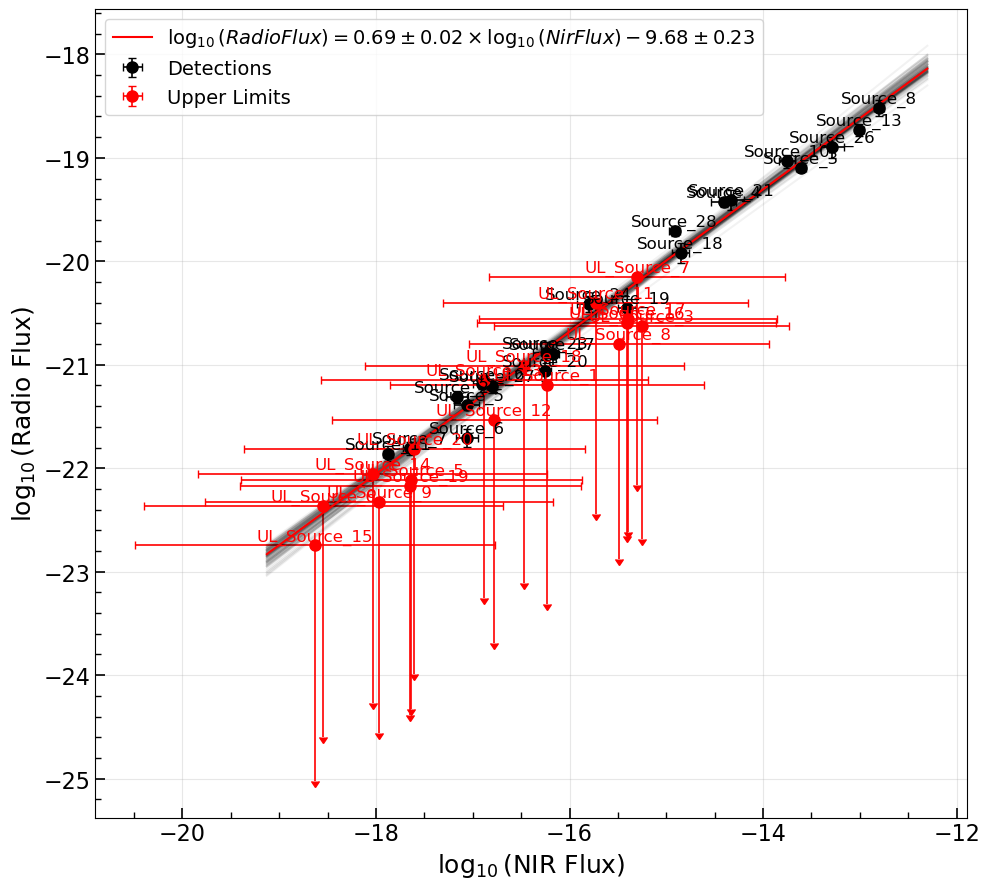

In [192]:
# Plot 1: Data and fit in log-log space
plt.figure(figsize=(10, 9))
plt.subplots_adjust(left=0.11, right=0.99, top=0.99, bottom=0.08)



# ----- Plot detections -----
plt.errorbar(
    x_det, y_det,
    xerr=x_err_det, yerr=y_err_det,
    fmt='o', color='black', ecolor='black',
    elinewidth=1.2, capsize=3, markersize=8,
    label='Detections'
)

# ----- Plot upper limits (red, downward arrows) -----
plt.errorbar(
    x_ul, y_ul ,
    xerr=x_err_ul, yerr=y_err_ul,
    uplims=True, fmt='o', color='red', ecolor='red',
    elinewidth=1.2, capsize=3, markersize=8,
    label='Upper Limits'
)

# ----- Annotate points -----
for i, name in enumerate(det_names):
    plt.text(x_det[i], y_det[i] + 0.05, name, fontsize=12, ha='center')

for i, name in enumerate(ul_names):
    plt.text(x_ul[i], y_ul[i] + 0.05, name, fontsize=12, ha='center', color='red')


x_plot = np.linspace(min(x_ul) - 0.5, max(x_det) + 0.5, 100)
for i in np.random.choice(len(slope_samples), 100, replace=False):
    plt.plot(x_plot, slope_samples[i] * x_plot + intercept_samples[i], 'k-', alpha=0.05)

plt.plot(x_plot, slope_median * x_plot + intercept_median, 'r-',
         label=r'$\log_{10}(Radio Flux) = %.2f \pm %.2f \times \log_{10}(Nir Flux)  %.2f \pm %.2f$' % 
         (slope_median, (slope_upper-slope_lower)/2, intercept_median, (intercept_upper-intercept_lower)/2) )


# ----- Axes labels -----
plt.xlabel(r'$\log_{10}(\mathrm{NIR\ Flux})$', fontsize=18)
plt.ylabel(r'$\log_{10}(\mathrm{Radio\ Flux})$', fontsize=18)

# ----- Aesthetic settings -----
plt.tick_params(axis='both', which='major', length=7, width=1.2, direction='in', labelsize=16)
plt.tick_params(axis='both', which='minor', length=4, width=1, direction='in')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True, alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()

plt.show()


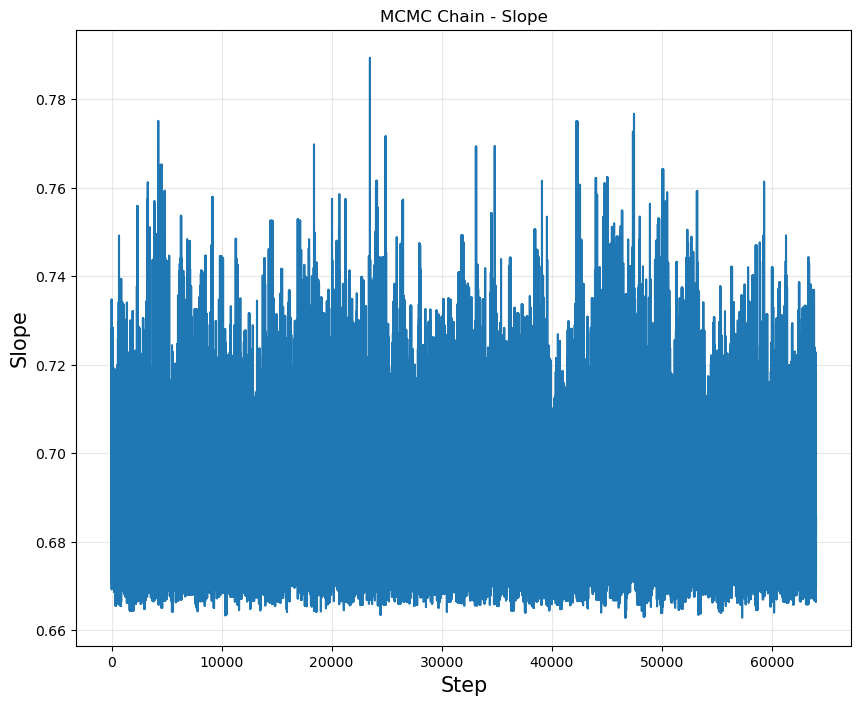

In [193]:
# Plot 2: MCMC chains
plt.figure(figsize=(10, 8))
plt.plot(samples[:, 0], label='Slope')
plt.ylabel('Slope', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.title('MCMC Chain - Slope')
plt.grid(True, alpha=0.3)
plt.show()


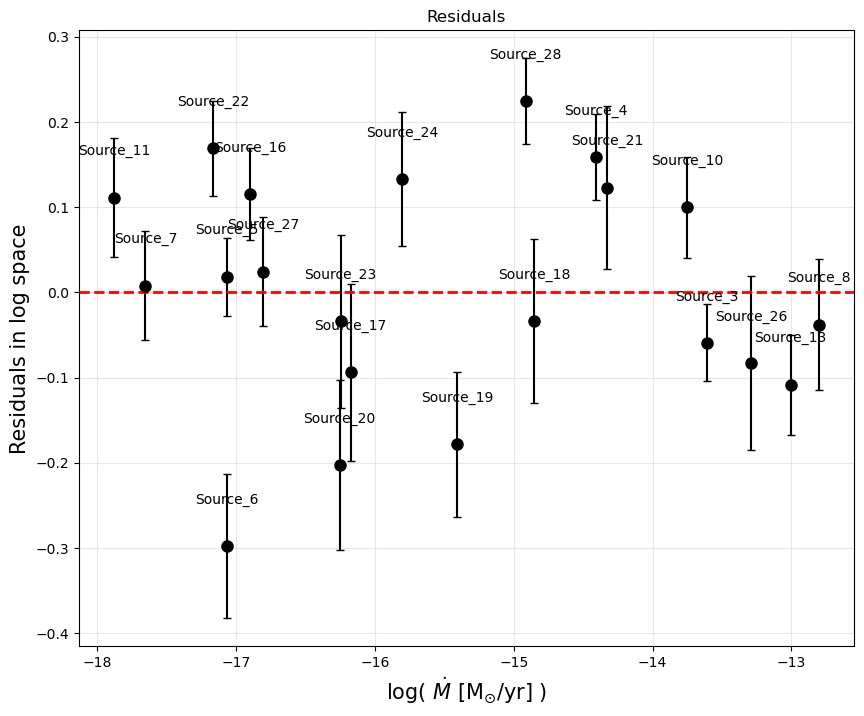

In [194]:
# Plot 3: Residuals in log space
plt.figure(figsize=(10, 8))
y_pred_det = slope_median * x_det + intercept_median
residuals = y_det - y_pred_det
plt.errorbar(x_det, residuals, yerr=y_err_det, fmt='o', color='black', capsize=3, markersize=8)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
for i in range(len(x_det)):
    plt.text(x_det[i], residuals[i] + 0.05, det_names[i], fontsize=10, ha='center')
plt.xlabel(r"log( $\dot{M}$ [M$_{\odot}$/yr] )", fontsize=15)
plt.ylabel('Residuals in log space', fontsize=15)
plt.title('Residuals')
plt.grid(True, alpha=0.3)
plt.show()

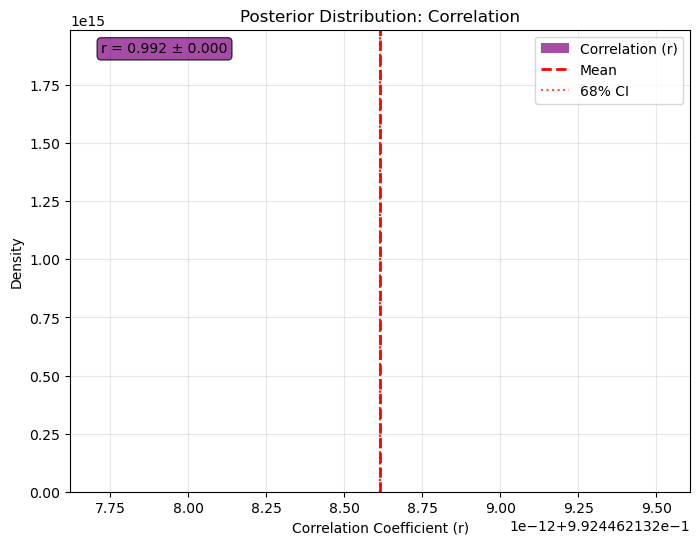

In [195]:
# Plot 4: Correlation coefficient posterior
plt.figure(figsize=(8, 6))
plt.hist(correlation_samples, bins=50, alpha=0.7, label='Correlation (r)', color='purple', density=True)
plt.axvline(correlation_mean, color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(correlation_ci[0], color='red', linestyle=':', alpha=0.7, label='68% CI')
plt.axvline(correlation_ci[1], color='red', linestyle=':', alpha=0.7)
plt.xlabel('Correlation Coefficient (r)')
plt.ylabel('Density')
plt.title('Posterior Distribution: Correlation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f'r = {correlation_mean:.3f} ± {correlation_std:.3f}', 
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='purple', alpha=0.7))
plt.show()

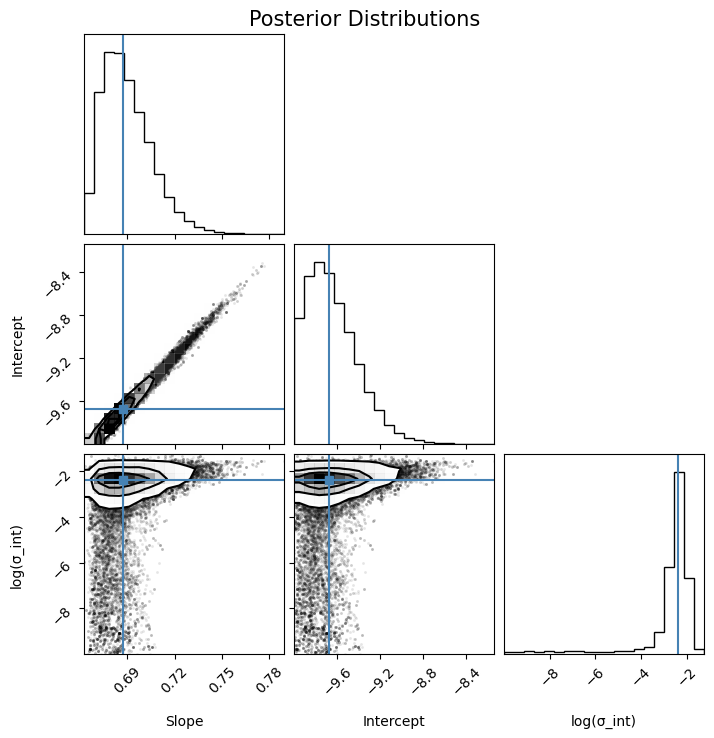

In [196]:
# Plot 5: Corner plot
fig = corner.corner(samples, labels=['Slope', 'Intercept', 'log(σ_int)'],
                    truths=[slope_median, intercept_median, np.log(sigma_int_median)],
                    title_kwargs={"fontsize": 12})
fig.suptitle('Posterior Distributions', fontsize=15)
plt.show()

In [197]:
# Print correlation coefficient
correlation = np.corrcoef(slope_samples, intercept_samples)[0, 1]
print(f"\nCorrelation between slope and intercept: {correlation:.3f}")

# Model comparison: calculate Bayesian Information Criterion (BIC)
n_data = len(x_det) + len(x_ul)
max_log_likelihood = log_likelihood(ml_params, x_det, y_det, x_err_det, y_err_det, x_ul, y_ul, x_err_ul)
bic = -2 * max_log_likelihood + ndim * np.log(n_data)
print(f"BIC: {bic:.2f}")

print(f"\nRegression equations:")
print(f"Log space: log₁₀(Radio_flux) = {slope_median:.3f} × log₁₀(Nir_flux) + {intercept_median:.3f}")
print(f"Linear space: Radio_flux = 10^{intercept_median:.3f} × (Nir_flux)^{slope_median:.3f}")
print(f"Power-law index: {slope_median:.3f} ± {(slope_upper-slope_lower)/2:.3f}")

# Calculate R-squared equivalent for detections only
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_det - np.mean(y_det))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"Pseudo R² (detections only): {r_squared:.3f}")

# Print data correlation coefficient
print(f"\nData correlation coefficient (r): {correlation_mean:.3f} ± {correlation_std:.3f}")

# Summary of slope constraint
print(f"\n" + "="*50)
print("SLOPE CONSTRAINT SUMMARY:")
print("="*50)
print(f"Slope range in prior: (0, 10)")
print(f"Fitted slope: {slope_median:.3f} +{slope_upper-slope_median:.3f} -{slope_median-slope_lower:.3f}")
print(f"All slope samples are positive: {np.all(slope_samples > 0)}")
print(f"Minimum slope sample: {np.min(slope_samples):.6f}")
print(f"Maximum slope sample: {np.max(slope_samples):.6f}")
print(f"\nFitting summary:")
print(f"Number of data points used for fitting: {len(x_det) + len(x_ul)}")
print(f"Fitting data range: x = [{np.min(x_det):.3f}, {np.max(x_det):.3f}], y = [{np.min(y_det):.3f}, {np.max(y_det):.3f}]")


Correlation between slope and intercept: 0.992
BIC: 21.30

Regression equations:
Log space: log₁₀(Radio_flux) = 0.688 × log₁₀(Nir_flux) + -9.679
Linear space: Radio_flux = 10^-9.679 × (Nir_flux)^0.688
Power-law index: 0.688 ± 0.015
Pseudo R² (detections only): 0.985

Data correlation coefficient (r): 0.992 ± 0.000

SLOPE CONSTRAINT SUMMARY:
Slope range in prior: (0, 10)
Fitted slope: 0.688 +0.018 -0.013
All slope samples are positive: True
Minimum slope sample: 0.662814
Maximum slope sample: 0.789331

Fitting summary:
Number of data points used for fitting: 38
Fitting data range: x = [-17.876, -12.803], y = [-21.859, -18.520]
